In [1]:
import pandas as pd

file_path =  "data/county_079/census_tract_metrics_with_accidents.csv"

data = pd.read_csv(file_path)

print(data.head())

   Census Tract        GEOID   Center_X   Center_Y  Tract Area (km^2)  \
0        160102  55079160102 -87.923202  42.916768          12.029618   
1        160101  55079160101 -87.894022  42.911161           4.932468   
2        160206  55079160206 -87.943958  42.879893           1.884080   
3        186900  55079186900 -87.887968  43.052311           0.434893   
4        187300  55079187300 -87.965630  42.887160           7.799945   

   Total Intersections  Intersection Density  Total Bus Stops  \
0                   27              2.244460               26   
1                    5              1.013691                0   
2                    1              0.530763                0   
3                   10             22.994167                6   
4                    7              0.897442                0   

   Bus-Stop Density  Total Parking Lots  ...  Length of Pedestrian Crosswalks  \
0          2.161332                  78  ...                         3.045118   
1       

In [29]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
import libpysal

#dependent variable
y = data['Pedestrian_Accidents'].values.reshape((-1, 1))

#independent variables
independent_vars = [
    "Intersection Density",
    "Bus-Stop Density", 
    "Parking-Lot/Space Density",
    "Length of Sidewalks",
    "Length of Bicycle Lanes"
]
X = data[independent_vars].values


coords = data[['Center_X', 'Center_Y']].values

In [4]:
from sklearn.model_selection import train_test_split


# Ensure that data is split consistently for features and coordinates
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size=0.2, random_state=42)

# Now, X_train should have shape (1218, 8) and coords_train should have shape (1218, 2)

print(X_train.shape, X_test.shape,coords_train.shape, y_train.shape)  # Check the shapes of the training and test sets

(241, 5) (61, 5) (241, 2) (241, 1)


In [5]:
import libpysal as ps
from mgwr.gwr import GWR
# Initialize the bandwidth selection method
selector = Sel_BW(coords_train, y_train, X_train, kernel='gaussian')
bandwidth = selector.search(criterion='CV')

# Fit the GWR model
model = GWR(coords_train,y_train, X_train, bandwidth)
results = model.fit()
print(results.summary())
# Check results
print(results.params)  # GWR parameters (coefficients)

Model type                                                         Gaussian
Number of observations:                                                 241
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          62560.039
Log-likelihood:                                                   -1011.834
AIC:                                                               2035.668
AICc:                                                              2038.149
BIC:                                                              61271.111
R2:                                                                   0.417
Adj. R2:                                                              0.405

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [6]:
print(type(coords_train))
print(coords_train[:5])  # Show first 5 elements


<class 'numpy.ndarray'>
[[-87.95409571  43.05977801]
 [-88.02755652  42.98457778]
 [-87.95619029  43.00289463]
 [-87.93887199  42.9702246 ]
 [-87.96214673  43.08620297]]


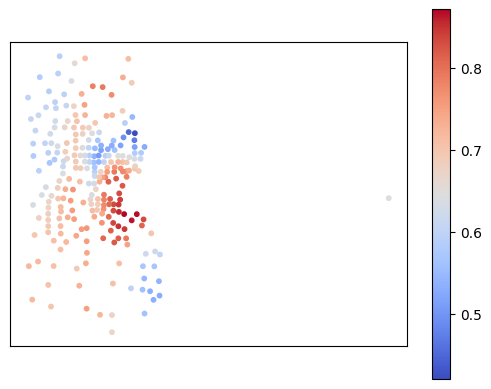

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load your local R² values
X_train2 = pd.DataFrame(results.localR2, columns=['R2'])

# Add latitude and longitude (Modify this based on your actual data source)
X_train2['x'] = coords_train[:, 0]  # Assuming X is the first column
X_train2['y'] = coords_train[:, 1]  # Assuming Y is the second column

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(X_train2['x'], X_train2['y'])]
gdf = gpd.GeoDataFrame(X_train2, geometry=geometry)

# Set coordinate reference system (CRS) - assuming WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Plot the spatial distribution of local R²
gdf.plot(column='R2', legend=True, cmap='coolwarm', markersize=10)

# Remove axis labels
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

# Save and display the map
plt.savefig('local_R2')
plt.show()

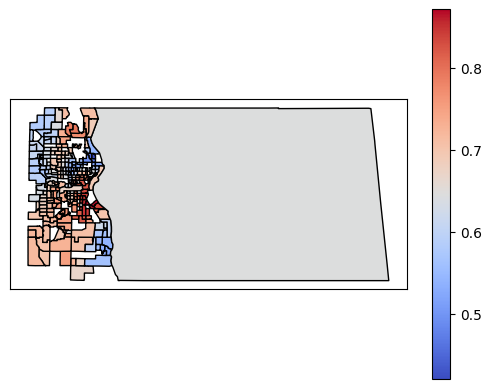

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 🔹 Load your shapefile (replace with actual file)
gdf_polygons = gpd.read_file("data/county_079/census_tracts.geojson")
# 🔹 Reproject polygons to the same CRS as the points (EPSG:4326)
gdf_polygons = gdf_polygons.to_crs("EPSG:4326")

# 🔹 Convert R² values into a GeoDataFrame with Points
X_train2 = pd.DataFrame(results.localR2, columns=['R2'])
X_train2['x'] = coords_train[:, 0]  # Replace with actual X coordinates
X_train2['y'] = coords_train[:, 1]  # Replace with actual Y coordinates
geometry = [Point(xy) for xy in zip(X_train2['x'], X_train2['y'])]
gdf_points = gpd.GeoDataFrame(X_train2, geometry=geometry, crs="EPSG:4326")

# 🔹 Reproject polygons to the same CRS as the points (EPSG:4326)
gdf_polygons = gdf_polygons.to_crs("EPSG:4326")

# 🔹 Spatial join: Assign R² values to the nearest polygon
gdf_joined = gpd.sjoin(gdf_polygons, gdf_points, how="left", predicate="contains")

# 🔹 Create a new column to group by (e.g., a unique identifier for each polygon)
gdf_joined['group_id'] = gdf_joined.index  # Or you can use a different column if you have one

# 🔹 Aggregate: If multiple points fall in the same polygon, take the mean R²
gdf_final = gdf_joined.dissolve(by="group_id", aggfunc={"R2": "mean"})

# 🔹 Plot the final R² spatial distribution
gdf_final.plot(column='R2', legend=True, cmap='coolwarm', edgecolor='black')
plt.xticks([])
plt.yticks([])
plt.savefig("local_R2")
plt.show()

In [9]:
results2 = model.predict(coords_test, X_test)
#results3 = model.predict(coords_train, X_train)

In [17]:
from sklearn.metrics import r2_score

# Using the test data to compare with predictions
y_test  # Actual values
y_pred = results2.predictions  # Predicted values for test set

# Compute R-squared between test actual values and test predictions
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5395801214738067


In [21]:
from sklearn.preprocessing import OneHotEncoder

# Check unique values in 'Land_Cover'
# print(f"Unique values in 'Land_Cover': {data['Land_Cover'].unique()}")

# Initialize OneHotEncoder (no need to specify sparse=False)
encoder = OneHotEncoder()

# Apply OneHotEncoder to the 'Land_Cover' column
land_cover_encoded = encoder.fit_transform(data[['GEOID']])

# Get the column names for the encoded data
land_cover_columns = encoder.get_feature_names_out(['GEOID'])

# Convert the encoded data into a DataFrame with appropriate column names
land_cover_df = pd.DataFrame(land_cover_encoded.toarray(), columns=land_cover_columns)

# Drop the original 'Land_Cover' column and concatenate the one-hot encoded columns
data_encoded = data.drop(columns=['GEOID'])
data_encoded = pd.concat([data_encoded, land_cover_df], axis=1)

# View the final DataFrame with encoded data
print(data_encoded)

# Now update the independent variables list to include the new one-hot encoded columns
independent_vars = independent_vars + list(land_cover_df.columns)  # Include the encoded land cover columns

# Extract the features (X)
independent_vars2 = data_encoded[independent_vars].values  # Now this should work

print(independent_vars2.shape)  # Check the shape of the feature matrix

# Now, you can proceed with model fitting, scaling, or splitting your dat

     Census Tract   Center_X   Center_Y  Tract Area (km^2)  \
0          160102 -87.923202  42.916768          12.029618   
1          160101 -87.894022  42.911161           4.932468   
2          160206 -87.943958  42.879893           1.884080   
3          186900 -87.887968  43.052311           0.434893   
4          187300 -87.965630  42.887160           7.799945   
..            ...        ...        ...                ...   
297         21700 -87.913106  42.940547          12.787803   
298          4500 -87.922269  43.085509           0.686741   
299          1000 -87.953489  43.124652           1.539976   
300          1100 -87.969014  43.127690           3.173124   
301          1200 -87.986201  43.126177           1.225292   

     Total Intersections  Intersection Density  Total Bus Stops  \
0                     27              2.244460               26   
1                      5              1.013691                0   
2                      1              0.530763        

In [22]:
print(independent_vars2.shape)  # Check the shape of the feature matrix

(302, 609)


In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the feature matrix X
independent_vars2_scaled = scaler.fit_transform(independent_vars2)
# Fit and transform the target variable y
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))  # Convert to NumPy array and reshape
print(independent_vars2_scaled.shape)  # Check the shape of the scaled features
print(y_scaled.shape)  # Check the shape of the scaled features

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
coords = data[['X', 'Y']].values  # Replace with your actual spatial coordinates

In [24]:
from sklearn.model_selection import train_test_split

# Assuming the dependent variable 'y' is already available (e.g., crash data or outcome variable)
# Replace 'y' with the actual target variable
y = data['Number of Crashes']  # Replace with the actual column name for your dependent variable


# Ensure that data is split consistently for features and coordinates
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    independent_vars2_scaled, y_scaled, coords, test_size=0.2, random_state=42)

# Now, X_train should have shape (1218, 23) and coords_train should have shape (1218, 2)

print(X_train.shape, X_test.shape,coords_train.shape, y_train.shape)  # Check the shapes of the training and test sets

KeyError: 'Number of Crashes'

In [ ]:
pip install mgwr

In [ ]:
import mgwr
print(dir(mgwr))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'diagnostics', 'gwr', 'kernels', 'search', 'sel_bw', 'summary']


In [ ]:
print(X_train.shape)

(1218, 23)


In [ ]:
print(coords_train.shape)  # Should be (n_samples, 2)

(1218, 2)


In [ ]:
print(y_train.shape)  # Should be (n_samples, 2)

(1218,)


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]

print(vif_data)

        VIF
0  3.995736
1  4.420947
2  2.148939
3  2.944924
4  2.732869


In [ ]:
pip instal mgwr-2.2.1

ERROR: unknown command "instal" - maybe you meant "install"


In [26]:
from mgwr.gwr import GWR
from mgwr import sel_bw

# Initialize the bandwidth selection method
selector = Sel_BW(coords_train, y_train, X_train)
bandwidth = selector.search()

# Fit the GWR model
model = GWR(coords_train,y_train, X_train, bandwidth)
results = model.fit()

# Check results
print(results.params)  # GWR parameters (coefficients)

[[-7.27349694e+00 -1.00632732e-01  1.56436075e+00 -6.07229285e-02
   1.88807515e+00 -5.15223116e+00]
 [ 6.73102566e-01 -2.41559765e-01  1.07099615e+00  1.54731257e-01
   4.25671173e-01 -4.26993234e-01]
 [-1.30389548e+01  5.49090333e-02  1.43222914e+00  1.28247510e-01
   1.04083729e+00 -4.48759681e+00]
 ...
 [-3.10071271e+01  6.56302153e-02  6.76924501e-01 -3.64375526e-03
   3.65763211e+00 -4.44078647e+00]
 [-3.54947982e+01  6.75855524e-02  2.02289411e+00  6.02304733e-02
   1.70829388e+00 -1.09826777e+00]
 [-2.48235663e+01  2.06889137e-02  5.58376038e-01  2.44133416e-02
   3.31158392e+00 -3.74824151e+00]]


In [27]:
# Extract feature matrix (X) and coordinates (X, Y)
X = data[independent_vars].values
coords = data[['X', 'Y']].values  # Replace with your actual spatial coordinates

# 1. **Scaling**: Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. **Train-Test Split**: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X_scaled, y, coords, test_size=0.2, random_state=42)

# 3. **Bandwidth Selection for GWR**: Use the training data to select bandwidth
selector = Sel_BW(coords_train, y_train, X_train)
bw = selector.search()

# 4. **Fitting GWR**: Fit the GWR model using the training data
gwr_model = GWR(coords_train, y_train, X_train, bw)
gwr_results = gwr_model.fit()

# Print GWR results summary
print(gwr_results.summary())

# 5. **Model Evaluation**: Predict on the training and test sets
y_train_pred = gwr_results.predict(X_train).predictions
y_test_pred = gwr_results.predict(X_test).predictions

# 6. **Performance Evaluation**:
# Training Mean Squared Error
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error (GWR): {train_mse}")

# Test Mean Squared Error
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error (GWR): {test_mse}")

KeyError: "['GEOID_55079000101', 'GEOID_55079000102', 'GEOID_55079000201', 'GEOID_55079000202', 'GEOID_55079000301', 'GEOID_55079000302', 'GEOID_55079000303', 'GEOID_55079000304', 'GEOID_55079000400', 'GEOID_55079000501', 'GEOID_55079000502', 'GEOID_55079000600', 'GEOID_55079000700', 'GEOID_55079000800', 'GEOID_55079000900', 'GEOID_55079001000', 'GEOID_55079001100', 'GEOID_55079001200', 'GEOID_55079001300', 'GEOID_55079001400', 'GEOID_55079001500', 'GEOID_55079001600', 'GEOID_55079001700', 'GEOID_55079001800', 'GEOID_55079001900', 'GEOID_55079002000', 'GEOID_55079002100', 'GEOID_55079002200', 'GEOID_55079002300', 'GEOID_55079002400', 'GEOID_55079002500', 'GEOID_55079002600', 'GEOID_55079002700', 'GEOID_55079002800', 'GEOID_55079002900', 'GEOID_55079003000', 'GEOID_55079003100', 'GEOID_55079003200', 'GEOID_55079003300', 'GEOID_55079003400', 'GEOID_55079003500', 'GEOID_55079003600', 'GEOID_55079003700', 'GEOID_55079003800', 'GEOID_55079003900', 'GEOID_55079004000', 'GEOID_55079004100', 'GEOID_55079004200', 'GEOID_55079004300', 'GEOID_55079004400', 'GEOID_55079004500', 'GEOID_55079004600', 'GEOID_55079004700', 'GEOID_55079004800', 'GEOID_55079004900', 'GEOID_55079005000', 'GEOID_55079005100', 'GEOID_55079005200', 'GEOID_55079005300', 'GEOID_55079005400', 'GEOID_55079005500', 'GEOID_55079005600', 'GEOID_55079005700', 'GEOID_55079005800', 'GEOID_55079005900', 'GEOID_55079006000', 'GEOID_55079006100', 'GEOID_55079006200', 'GEOID_55079006300', 'GEOID_55079006400', 'GEOID_55079006500', 'GEOID_55079006600', 'GEOID_55079006700', 'GEOID_55079006800', 'GEOID_55079006900', 'GEOID_55079007000', 'GEOID_55079007100', 'GEOID_55079007200', 'GEOID_55079007300', 'GEOID_55079007400', 'GEOID_55079007500', 'GEOID_55079007600', 'GEOID_55079007700', 'GEOID_55079007800', 'GEOID_55079007900', 'GEOID_55079008000', 'GEOID_55079008100', 'GEOID_55079008400', 'GEOID_55079008500', 'GEOID_55079008600', 'GEOID_55079008700', 'GEOID_55079008800', 'GEOID_55079008900', 'GEOID_55079009000', 'GEOID_55079009100', 'GEOID_55079009200', 'GEOID_55079009300', 'GEOID_55079009400', 'GEOID_55079009500', 'GEOID_55079009600', 'GEOID_55079009700', 'GEOID_55079009800', 'GEOID_55079009900', 'GEOID_55079010600', 'GEOID_55079010700', 'GEOID_55079010800', 'GEOID_55079011000', 'GEOID_55079011100', 'GEOID_55079011200', 'GEOID_55079011300', 'GEOID_55079011400', 'GEOID_55079012200', 'GEOID_55079012300', 'GEOID_55079012400', 'GEOID_55079012500', 'GEOID_55079012600', 'GEOID_55079012700', 'GEOID_55079012800', 'GEOID_55079012900', 'GEOID_55079013000', 'GEOID_55079013300', 'GEOID_55079013400', 'GEOID_55079013500', 'GEOID_55079013600', 'GEOID_55079013700', 'GEOID_55079014100', 'GEOID_55079014300', 'GEOID_55079014400', 'GEOID_55079014600', 'GEOID_55079014700', 'GEOID_55079014800', 'GEOID_55079014900', 'GEOID_55079015700', 'GEOID_55079015800', 'GEOID_55079015900', 'GEOID_55079016000', 'GEOID_55079016100', 'GEOID_55079016200', 'GEOID_55079016300', 'GEOID_55079016400', 'GEOID_55079016500', 'GEOID_55079016600', 'GEOID_55079016700', 'GEOID_55079016800', 'GEOID_55079016900', 'GEOID_55079017000', 'GEOID_55079017100', 'GEOID_55079017200', 'GEOID_55079017300', 'GEOID_55079017400', 'GEOID_55079017500', 'GEOID_55079017600', 'GEOID_55079017900', 'GEOID_55079018000', 'GEOID_55079018100', 'GEOID_55079018200', 'GEOID_55079018300', 'GEOID_55079018400', 'GEOID_55079018500', 'GEOID_55079018600', 'GEOID_55079018700', 'GEOID_55079018800', 'GEOID_55079018900', 'GEOID_55079019000', 'GEOID_55079019100', 'GEOID_55079019200', 'GEOID_55079019300', 'GEOID_55079019400', 'GEOID_55079019500', 'GEOID_55079019600', 'GEOID_55079019700', 'GEOID_55079019800', 'GEOID_55079019900', 'GEOID_55079020000', 'GEOID_55079020100', 'GEOID_55079020200', 'GEOID_55079020300', 'GEOID_55079020400', 'GEOID_55079020500', 'GEOID_55079020600', 'GEOID_55079020700', 'GEOID_55079020800', 'GEOID_55079020900', 'GEOID_55079021000', 'GEOID_55079021100', 'GEOID_55079021200', 'GEOID_55079021300', 'GEOID_55079021400', 'GEOID_55079021500', 'GEOID_55079021600', 'GEOID_55079021700', 'GEOID_55079021800', 'GEOID_55079030100', 'GEOID_55079035100', 'GEOID_55079035200', 'GEOID_55079040100', 'GEOID_55079050101', 'GEOID_55079050103', 'GEOID_55079050104', 'GEOID_55079060101', 'GEOID_55079060102', 'GEOID_55079060200', 'GEOID_55079070100', 'GEOID_55079070200', 'GEOID_55079070300', 'GEOID_55079080100', 'GEOID_55079080200', 'GEOID_55079080300', 'GEOID_55079080400', 'GEOID_55079090100', 'GEOID_55079090200', 'GEOID_55079090300', 'GEOID_55079090600', 'GEOID_55079090700', 'GEOID_55079090800', 'GEOID_55079090900', 'GEOID_55079091000', 'GEOID_55079091100', 'GEOID_55079091200', 'GEOID_55079091300', 'GEOID_55079091400', 'GEOID_55079100100', 'GEOID_55079100200', 'GEOID_55079100300', 'GEOID_55079100400', 'GEOID_55079100500', 'GEOID_55079100600', 'GEOID_55079100700', 'GEOID_55079100800', 'GEOID_55079100900', 'GEOID_55079101000', 'GEOID_55079101100', 'GEOID_55079101200', 'GEOID_55079101300', 'GEOID_55079101400', 'GEOID_55079101500', 'GEOID_55079101600', 'GEOID_55079101700', 'GEOID_55079101800', 'GEOID_55079110100', 'GEOID_55079120101', 'GEOID_55079120102', 'GEOID_55079120201', 'GEOID_55079120202', 'GEOID_55079120203', 'GEOID_55079120300', 'GEOID_55079120400', 'GEOID_55079120501', 'GEOID_55079120502', 'GEOID_55079130100', 'GEOID_55079130200', 'GEOID_55079140100', 'GEOID_55079140201', 'GEOID_55079140202', 'GEOID_55079150100', 'GEOID_55079150301', 'GEOID_55079150303', 'GEOID_55079150304', 'GEOID_55079160101', 'GEOID_55079160102', 'GEOID_55079160202', 'GEOID_55079160203', 'GEOID_55079160205', 'GEOID_55079160206', 'GEOID_55079160301', 'GEOID_55079160302', 'GEOID_55079170100', 'GEOID_55079170200', 'GEOID_55079170300', 'GEOID_55079170400', 'GEOID_55079170500', 'GEOID_55079170600', 'GEOID_55079170700', 'GEOID_55079180100', 'GEOID_55079180200', 'GEOID_55079180300', 'GEOID_55079180400', 'GEOID_55079180500', 'GEOID_55079185100', 'GEOID_55079185200', 'GEOID_55079185300', 'GEOID_55079185400', 'GEOID_55079185500', 'GEOID_55079185600', 'GEOID_55079185700', 'GEOID_55079185800', 'GEOID_55079185900', 'GEOID_55079186000', 'GEOID_55079186100', 'GEOID_55079186200', 'GEOID_55079186300', 'GEOID_55079186400', 'GEOID_55079186500', 'GEOID_55079186600', 'GEOID_55079186800', 'GEOID_55079186900', 'GEOID_55079187000', 'GEOID_55079187200', 'GEOID_55079187300', 'GEOID_55079187400', 'GEOID_55079980000', 'GEOID_55079990000'] not in index"

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  # or any other model
from sklearn.metrics import mean_squared_error  # or any other metric based on your problem

# Assuming 'y' is your dependent variable (e.g., 'Number of Crashes')
y = data['Number of Crashes'].values  # Dependent variable (target)

# 1. **Scaling**: Apply StandardScaler to the features (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. **Train-Test Split**: Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. **Model Training**: Fit a model (using Linear Regression as an example)
model = LinearRegression()
model.fit(X_train, y_train)

# 4. **Training Evaluation**: Predict on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

# 5. **Testing Evaluation**: Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Testing Mean Squared Error: {test_mse}")

# Optionally: You can also evaluate using R-squared, MAE, or other metrics

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Example: Numeric categorical data
data = pd.DataFrame({'Land_Cover': [11, 21, 22, 23, 24,31,41,42,43,52,71,81,82,90,95]})

# Apply One-Hot Encoding (default behavior returns sparse matrix)
encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[['Land_Cover']])

# Convert the sparse matrix to a dense array
encoded_dense = encoded.toarray()

# Convert back to DataFrame
land_cover_encoded = pd.DataFrame(encoded_dense, columns=encoder.get_feature_names_out(['Land_Cover']))

# Concatenate with original data
data = pd.concat([data, land_cover_encoded], axis=1)

print(data)

    Land_Cover  Land_Cover_11  Land_Cover_21  Land_Cover_22  Land_Cover_23  \
0           11            1.0            0.0            0.0            0.0   
1           21            0.0            1.0            0.0            0.0   
2           22            0.0            0.0            1.0            0.0   
3           23            0.0            0.0            0.0            1.0   
4           24            0.0            0.0            0.0            0.0   
5           31            0.0            0.0            0.0            0.0   
6           41            0.0            0.0            0.0            0.0   
7           42            0.0            0.0            0.0            0.0   
8           43            0.0            0.0            0.0            0.0   
9           52            0.0            0.0            0.0            0.0   
10          71            0.0            0.0            0.0            0.0   
11          81            0.0            0.0            0.0     

In [ ]:
# Update independent variables to include the encoded columns
independent_vars = [
    'ACS_PCT_MARRIED_SP_PR_F',
    'ACS_PCT_IN_COUNTY_MOVE',
    'ACS_PCT_WORK_RES_F',
    'CEN_POPDENSITY_TRACT',
    'ACS_MEDIAN_YEAR_BUILT',
    'ACS_PCT_DRIVE_2WORK',
    'ACS_MEDIAN_HH_INC',
    'ACS_PCT_PERSON_INC_BELOW99'
] + list(land_cover_df.columns)  # Include the encoded land cover columns

X = data_encoded[independent_vars].values  # Use the encoded independent variables


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming you have continuous variables besides the encoded categories
X = data.drop(columns=['Land_Cover'])  # Drop the original categorical column

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale only continuous features

In [ ]:
print(X_scaled.shape)  # Check the shape of the features (X)
print(y.shape)         # Check the shape of the target variable (y)

(15, 15)
(1523, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [15, 1523]

In [31]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
import libpysal


X = data[independent_vars].values


coords = data[['Center_X', 'Center_Y']].values

#bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords, y, X)
bw = selector.search()

#fit GWPR model
gwpr_model = GWR(coords, y, X, bw)
gwpr_results = gwpr_model.fit()

print(gwpr_results.summary())


Model type                                                         Gaussian
Number of observations:                                                 302
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          80671.436
Log-likelihood:                                                   -1272.264
AIC:                                                               2556.528
AICc:                                                              2558.909
BIC:                                                              78981.150
R2:                                                                   0.418
Adj. R2:                                                              0.408

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [32]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# # dependent variable
# y = data['Number of Crashes'].values.reshape((-1, 1))

# # independent variables
# independent_vars = [
#     'ACS_PCT_MARRIED_SP_PR_F',
#     'ACS_PCT_IN_COUNTY_MOVE',
#     'ACS_PCT_WORK_RES_F',
#     'CEN_POPDENSITY_TRACT',
#     'ACS_MEDIAN_YEAR_BUILT',
#     'ACS_PCT_DRIVE_2WORK',
#     'ACS_MEDIAN_HH_INC',
#     'ACS_PCT_PERSON_INC_BELOW99','Land_Cover'
# ]
# X = data[independent_vars].values

# coords = data[['X', 'Y']].values

# bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords, y, X)
bw = selector.search()

# fit GWPR model
gwpr_model = GWR(coords, y, X, bw, family=Poisson())

gwpr_results = gwpr_model.fit()

# Use the model to predict the dependent variable for the same data or another test set
predictions = gwpr_model.predict(coords, X)

# Get predicted values
y_pred = predictions.predictions  # Get the predicted values

# Calculate R-squared
ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)  # R-squared formula

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print results
print(gwpr_results.summary())
print(f"R-squared: {r_squared}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Model type                                                          Poisson
Number of observations:                                                 302
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          2697.846
Log-likelihood:                                                   -2057.225
AIC:                                                               4126.450
AICc:                                                              2710.131
BIC:                                                               1007.560
Percent deviance explained:                                           0.426
Adj. percent deviance explained:                                      0.416

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [35]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# # dependent variable
# y = data['Number of Crashes'].values.reshape((-1, 1))

# # independent variables
# independent_vars = [
#     'ACS_PCT_MARRIED_SP_PR_F',
#     'ACS_PCT_IN_COUNTY_MOVE',
#     'ACS_PCT_WORK_RES_F',
#     'CEN_POPDENSITY_TRACT',
#     'ACS_MEDIAN_YEAR_BUILT',
#     'ACS_PCT_DRIVE_2WORK',
#     'ACS_MEDIAN_HH_INC',
#     'ACS_PCT_PERSON_INC_BELOW99'
# ]
# X = data[independent_vars].values

# coords = data[['X', 'Y']].values

# Scaling the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X_scaled, y, coords, test_size=0.2, random_state=42)

# Bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords_train, y_train, X_train)
bw = selector.search()

# Fit GWPR model using the training data
gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
gwpr_model_fit = gwpr_model.fit()

# Get the predicted values for the test set
# Using the 'predict' method on the fitted model (gwpr_model)
predictions = gwpr_model.predict(coords_test, X_test)
y_pred = predictions.predictions

# Global R-squared (model fit on all data)
ss_res_global = np.sum((y_test - y_pred) ** 2)  # Residual sum of squares for the test set
ss_tot_global = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares for the test set
r_squared_global = 1 - (ss_res_global / ss_tot_global)  # R-squared formula

# Local R-squared (calculated per observation in the test set)
residuals = gwpr_model_fit.resid_response
ss_tot_local = np.sum((y_test - np.mean(y_test)) ** 2, axis=0)  # Total sum of squares for each test observation
r_squared_local = 1 - (residuals ** 2 / ss_tot_local)

# Output the results
print(f"Global R-squared: {r_squared_global}")
print(f"Local R-squared values: {r_squared_local}")

# Calculate Mean Squared Error for test set
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

# Optionally, you can also check the summary of the fitted model
print(gwpr_model_fit.summary())

Global R-squared: -1.00947087031368
Local R-squared values: [0.98561054 0.9995605  0.99710208 0.99922828 0.99607836 0.99903373
 0.99840964 0.99822532 0.98258165 0.99949676 0.99992054 0.97292583
 0.99967341 0.9835212  0.99959734 0.99999743 0.99747951 0.9999956
 0.99372479 0.99743686 0.99823701 0.9980758  0.99825728 0.9881816
 0.99906482 0.99870599 0.99992803 0.99997201 0.99929153 0.99121491
 0.99671461 0.9988042  0.99478454 0.99996916 0.97118542 0.99523369
 0.99940145 0.99995576 0.99910362 0.99884477 0.99808055 0.99913479
 0.99998434 0.99851944 0.99862798 0.99967516 0.99974919 0.99917208
 0.99804623 0.99831571 0.99889564 0.99951997 0.99515744 0.9998395
 0.99930205 0.99427767 0.97095341 0.99998745 0.99970479 0.99032095
 0.9994612  0.99693701 0.99985876 0.99862891 0.99841539 0.99992161
 0.99997765 0.99994821 0.99831788 0.99995479 0.99925155 0.99940748
 0.98839135 0.99946199 0.99245898 0.98919112 0.99987687 0.99999646
 0.99737985 0.99580762 0.97081465 0.99594465 0.99977266 0.99730558
 0.94

In [36]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# # dependent variable
# y = data['Number of Crashes'].values.reshape((-1, 1))

# # independent variables
# independent_vars = [
#     'ACS_PCT_MARRIED_SP_PR_F',
#     'ACS_PCT_IN_COUNTY_MOVE',
#     'ACS_PCT_WORK_RES_F',
#     'CEN_POPDENSITY_TRACT',
#     'ACS_MEDIAN_YEAR_BUILT',
#     'ACS_PCT_DRIVE_2WORK',
#     'ACS_MEDIAN_HH_INC',
#     'ACS_PCT_PERSON_INC_BELOW99'
# ]
# X = data[independent_vars].values

# coords = data[['X', 'Y']].values

# Scaling the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X_scaled, y, coords, test_size=0.2, random_state=42)

# Bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords_train, y_train, X_train)
bw = selector.search()

# Fit GWPR model using the training data
gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
gwpr_model_fit = gwpr_model.fit()

# Get the predicted values for the test set
predictions_test = gwpr_model.predict(coords_test, X_test)
y_pred_test = predictions_test.predictions

# Get the predicted values for the training set
predictions_train = gwpr_model.predict(coords_train, X_train)
y_pred_train = predictions_train.predictions

# Global R-squared (model fit on all data)
y_pred_all = gwpr_model.predict(coords, X_scaled).predictions  # Predictions on all data
ss_res_global = np.sum((y - y_pred_all) ** 2)  # Residual sum of squares for all data
ss_tot_global = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares for all data
r_squared_global = 1 - (ss_res_global / ss_tot_global)  # R-squared formula

# R-squared for training set
ss_res_train = np.sum((y_train - y_pred_train) ** 2)  # Residual sum of squares for training set
ss_tot_train = np.sum((y_train - np.mean(y_train)) ** 2)  # Total sum of squares for training set
r_squared_train = 1 - (ss_res_train / ss_tot_train)  # R-squared formula

# R-squared for test set
ss_res_test = np.sum((y_test - y_pred_test) ** 2)  # Residual sum of squares for test set
ss_tot_test = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares for test set
r_squared_test = 1 - (ss_res_test / ss_tot_test)  # R-squared formula

# Output the results
print(f"Global R-squared: {r_squared_global}")
print(f"Training R-squared: {r_squared_train}")
print(f"Test R-squared: {r_squared_test}")

# Calculate Mean Squared Error for test set
mse = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error on Test Set: {mse}")

# Optionally, you can also check the summary of the fitted model
print(gwpr_model_fit.summary())

ValueError: operands could not be broadcast together with shapes (241,) (61,) 

In [37]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# # dependent variable
# y = data['Number of Crashes'].values.reshape((-1, 1))

# # independent variables
# independent_vars = [
#     'ACS_PCT_MARRIED_SP_PR_F',
#     'ACS_PCT_IN_COUNTY_MOVE',
#     'ACS_PCT_WORK_RES_F',
#     'CEN_POPDENSITY_TRACT',
#     'ACS_MEDIAN_YEAR_BUILT',
#     'ACS_PCT_DRIVE_2WORK',
#     'ACS_MEDIAN_HH_INC',
#     'ACS_PCT_PERSON_INC_BELOW99'
# ]
# X = data[independent_vars].values

# coords = data[['X', 'Y']].values

# Scaling the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X_scaled, y, coords, test_size=0.2, random_state=42)

# Bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords_train, y_train, X_train)
bw = selector.search()

# Fit GWPR model using the training data
gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
gwpr_model_fit = gwpr_model.fit()

# Get the predicted values for the test set
predictions_test = gwpr_model.predict(coords_test, X_test)
y_pred_test = predictions_test.predictions

# Get the predicted values for the training set
predictions_train = gwpr_model.predict(coords_train, X_train)
y_pred_train = predictions_train.predictions

# Global R-squared (model fit on all data)
y_pred_all = gwpr_model.predict(coords, X_scaled).predictions  # Predictions on all data
ss_res_global = np.sum((y - y_pred_all) ** 2)  # Residual sum of squares for all data
ss_tot_global = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares for all data
r_squared_global = 1 - (ss_res_global / ss_tot_global)  # R-squared formula

# R-squared for training set
ss_res_train = np.sum((y_train - y_pred_train) ** 2)  # Residual sum of squares for training set
ss_tot_train = np.sum((y_train - np.mean(y_train)) ** 2)  # Total sum of squares for training set
r_squared_train = 1 - (ss_res_train / ss_tot_train)  # R-squared formula

# R-squared for test set
ss_res_test = np.sum((y_test - y_pred_test) ** 2)  # Residual sum of squares for test set
ss_tot_test = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares for test set
r_squared_test = 1 - (ss_res_test / ss_tot_test)  # R-squared formula

# Output the results
print(f"Global R-squared: {r_squared_global}")
print(f"Training R-squared: {r_squared_train}")
print(f"Test R-squared: {r_squared_test}")

# Calculate Mean Squared Error for test set
mse = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error on Test Set: {mse}")

# Optionally, you can also check the summary of the fitted model
print(gwpr_model_fit.summary())

ValueError: operands could not be broadcast together with shapes (241,) (61,) 

Mean Squared Error (Test Set): 1025.4112217036902
Mean Absolute Error (Test Set): 23.121295371577435
Global R-squared: -1.00947087031368
Average MSE across folds: 921.8407597604071
Average MAE across folds: 21.975096553352756


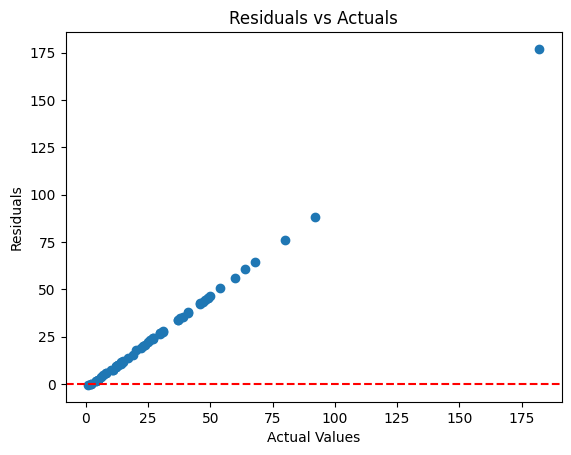

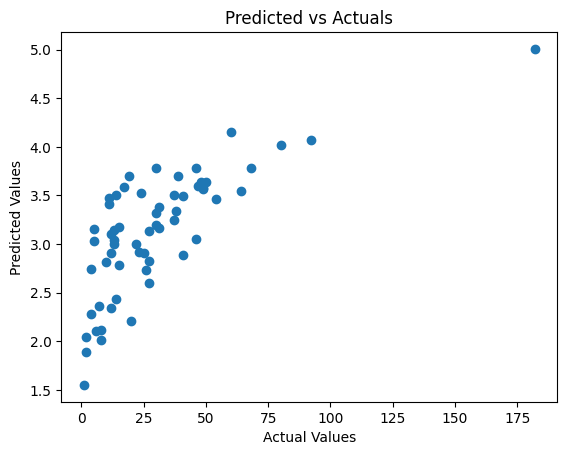

Model type                                                          Poisson
Number of observations:                                                 242
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          2042.640
Log-likelihood:                                                   -1584.315
AIC:                                                               3180.630
AICc:                                                              2054.998
BIC:                                                                747.251
Percent deviance explained:                                           0.397
Adj. percent deviance explained:                                      0.385

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [38]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# # dependent variable
# y = data['Number of Crashes'].values.reshape((-1, 1))

# # independent variables
# independent_vars = [
#     'ACS_PCT_MARRIED_SP_PR_F',
#     'ACS_PCT_IN_COUNTY_MOVE',
#     'ACS_PCT_WORK_RES_F',
#     'CEN_POPDENSITY_TRACT',
#     'ACS_MEDIAN_YEAR_BUILT',
#     'ACS_PCT_DRIVE_2WORK',
#     'ACS_MEDIAN_HH_INC',
#     'ACS_PCT_PERSON_INC_BELOW99'
# ]
# X = data[independent_vars].values

# coords = data[['X', 'Y']].values

# Scaling the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X_scaled, y, coords, test_size=0.2, random_state=42)

# Bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords_train, y_train, X_train)
bw = selector.search()

# Fit GWPR model using the training data
gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
gwpr_model_fit = gwpr_model.fit()

# Get the predicted values for the test set
predictions = gwpr_model.predict(coords_test, X_test)
y_pred = predictions.predictions

# Calculate Mean Squared Error and Mean Absolute Error for test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error (Test Set): {mse_test}')
print(f'Mean Absolute Error (Test Set): {mae_test}')

# Global R-squared (using the entire test set)
ss_res_global = np.sum((y_test - y_pred) ** 2)  # Residual sum of squares for the test set
ss_tot_global = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares for the test set
r_squared_global = 1 - (ss_res_global / ss_tot_global)  # R-squared formula
print(f"Global R-squared: {r_squared_global}")

# Cross-validation to evaluate model stability
kf = KFold(n_splits=5, random_state=42, shuffle=True)
mse_folds = []
mae_folds = []

for train_index, test_index in kf.split(data):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    coords_train, coords_test = coords[train_index], coords[test_index]

    # Perform bandwidth selection, model fitting, and prediction as before
    selector = Sel_BW(coords_train, y_train, X_train)
    bw = selector.search()
    gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
    gwpr_model_fit = gwpr_model.fit()
    predictions = gwpr_model.predict(coords_test, X_test)
    y_pred = predictions.predictions

    # Calculate MSE and MAE for this fold
    mse_folds.append(mean_squared_error(y_test, y_pred))
    mae_folds.append(mean_absolute_error(y_test, y_pred))

# Report average performance across folds
print(f'Average MSE across folds: {np.mean(mse_folds)}')
print(f'Average MAE across folds: {np.mean(mae_folds)}')

# Visual Evaluation - Residuals vs Actuals Plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actuals')
plt.show()

# Visual Evaluation - Predicted vs Actuals Plot
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actuals')
plt.show()

# Optionally, check the summary of the fitted model
print(gwpr_model_fit.summary())

In [ ]:
X_test.shape

(305, 8)

In [ ]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# dependent variable
y = data['Number of Crashes'].values.reshape((-1, 1))

# independent variables
independent_vars = [
    'ACS_PCT_MARRIED_SP_PR_F',
    'ACS_PCT_IN_COUNTY_MOVE',
    'ACS_PCT_WORK_RES_F',
    'CEN_POPDENSITY_TRACT',
    'ACS_MEDIAN_YEAR_BUILT',
    'ACS_PCT_DRIVE_2WORK',
    'ACS_MEDIAN_HH_INC',
    'ACS_PCT_PERSON_INC_BELOW99'
]
X = data[independent_vars].values

coords = data[['X', 'Y']].values

# bandwidth selection for GWPR using Poisson family
selector = Sel_BW(coords, y, X)
bw = selector.search()

# fit GWPR model
gwpr_model = GWR(coords, y, X, bw, family=Poisson())

# fit the model
gwpr_model_fit = gwpr_model.fit()

# Get the predicted values
predictions = gwpr_model_fit.predict(coords, X)
y_pred = predictions.predictions

# Global R-squared (model fit on all data)
ss_res_global = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot_global = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared_global = 1 - (ss_res_global / ss_tot_global)  # R-squared formula

# Local R-squared (calculated per observation)
residuals = gwpr_model_fit.resid_response
ss_tot_local = np.sum((y - np.mean(y)) ** 2, axis=0)  # Total sum of squares for each observation
r_squared_local = 1 - (residuals ** 2 / ss_tot_local)

# Output the results
print(f"Global R-squared: {r_squared_global}")
print(f"Local R-squared values: {r_squared_local}")

# Optionally, you can also check the summary of the fitted model
print(gwpr_model_fit.summary())

AttributeError: 'GWRResults' object has no attribute 'predict'

In [40]:
from sklearn.preprocessing import StandardScaler
from spglm.family import Gaussian  # Trying Gaussian if Poisson doesn't work well

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to perform k-fold cross-validation for GWPR
def kfold_gwpr(data, independent_vars, dependent_var, coords, k=3):
    y = data[dependent_var].values.reshape((-1, 1))
    X = data[independent_vars].values

    # Scale the features
    X_scaled = StandardScaler().fit_transform(X)

    prediction_errors = []
    r_squared_values = []  # List to store R-squared values

    kf = KFold(n_splits=k)

    for train_index, test_index in kf.split(data):
        # Split data into training and testing sets
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coords_train, coords_test = coords[train_index], coords[test_index]

        # Bandwidth selection for training data
        selector = Sel_BW(coords_train, y_train, X_train)
        bw = selector.search()
        print("Selected Bandwidth:", bw)  # Check bandwidth

        # Fit the GWPR model on the training data
        gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Gaussian())  # Using Gaussian for count-like data
        gwpr_results = gwpr_model.fit()

        # Predict the outcome for the test set
        predictions = gwpr_model.predict(coords_test, X_test)
        y_pred = predictions.predictions  # Get predictions from the result
        # Print the predicted and actual values
        print(f"Predicted values: {y_pred}")
        print(f"Actual values: {y_test}")
        # Calculate prediction error (Squared Error) for each fold
        fold_error = mean_squared_error(y_test, y_pred)
        prediction_errors.append(fold_error)

         # Calculate R-squared for each fold
        ss_res = np.sum((y_test - y_pred) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot)  # R-squared formula
        r_squared_values.append(r_squared)

    # Return the mean squared error and average R-squared
    return np.mean(prediction_errors), np.mean(r_squared_values)


# Example usage of k-fold cross-validation
kfold_error = kfold_gwpr(data, independent_vars, 'Pedestrian_Accidents', data[['Center_X', 'Center_Y']].values, k=3)
print(f"k-Fold Mean Squared Error: {kfold_error}")
print(f"k-Fold Average R-squared: {kfold_r_squared}")

Selected Bandwidth: 96.0
Predicted values: [[23.14502205]
 [ 6.47247629]
 [ 2.54134897]
 [ 7.14945501]
 [ 4.44642855]
 [15.67165326]
 [29.68844147]
 [ 9.97384039]
 [ 3.52372396]
 [40.46869015]
 [ 4.60489617]
 [ 5.81908112]
 [42.77232429]
 [42.83549574]
 [47.04552999]
 [35.80524261]
 [46.34967783]
 [28.53562347]
 [36.76212716]
 [33.94105917]
 [28.88874424]
 [45.70868162]
 [10.39707633]
 [ 8.67330505]
 [12.50048892]
 [ 6.24957107]
 [40.66978785]
 [41.06164942]
 [29.52083547]
 [32.28841805]
 [13.44616891]
 [15.0215971 ]
 [16.3804184 ]
 [26.89245848]
 [26.11987629]
 [28.87878799]
 [30.51722601]
 [38.15423115]
 [44.97517094]
 [46.13274187]
 [34.96445382]
 [36.02402557]
 [35.03139957]
 [32.88604354]
 [41.44224462]
 [11.97256546]
 [37.14507466]
 [20.61543528]
 [ 8.4614603 ]
 [34.39379797]
 [92.53155505]
 [12.46371315]
 [12.40946136]
 [78.01525036]
 [40.06327971]
 [33.22106159]
 [11.22043539]
 [ 8.10660889]
 [12.68875763]
 [18.92846456]
 [29.14733574]
 [19.00704009]
 [22.60795091]
 [22.4703820

NameError: name 'kfold_r_squared' is not defined

NameError: name 'y_pred' is not defined

In [ ]:
print(f"k-Fold Mean Squared Error: {kfold_error}")

k-Fold Mean Squared Error: 561.5498145328854


In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Function to perform k-fold cross-validation for GWPR
def kfold_gwpr(data, independent_vars, dependent_var, coords, k=5):
    y = data[dependent_var].values.reshape((-1, 1))
    X = data[independent_vars].values

    prediction_errors = []

    kf = KFold(n_splits=k)

    for train_index, test_index in kf.split(data):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coords_train, coords_test = coords[train_index], coords[test_index]

        # Bandwidth selection for training data
        selector = Sel_BW(coords_train, y_train, X_train)
        bw = selector.search()

        # Fit the GWPR model on the training data
        gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
        gwpr_results = gwpr_model.fit()

        # Predict the outcome for the test set
        predictions = gwpr_model.predict(coords_test, X_test)
        y_pred = predictions.predictions  # Get predictions from the result

        # Calculate prediction error (Squared Error) for each fold
        fold_error = mean_squared_error(y_test, y_pred)
        prediction_errors.append(fold_error)

    # Return the mean squared error of all folds
    return np.mean(prediction_errors)

# Example usage of k-fold cross-validation
kfold_error = kfold_gwpr(data, independent_vars, 'Pedestrian_Accidents', data[['Center_X', 'Center_Y']].values, k=5)
print(f"k-Fold Mean Squared Error: {kfold_error}")

k-Fold Mean Squared Error: 922.42434171023


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Function to perform k-fold cross-validation for GWPR and calculate R-squared
def kfold_gwpr(data, independent_vars, dependent_var, coords, k=5):
    y = data[dependent_var].values.reshape((-1, 1))  # Dependent variable
    X = data[independent_vars].values  # Independent variables

    prediction_errors = []  # List to store MSE values
    r_squared_values = []  # List to store R-squared values

    kf = KFold(n_splits=k)

    for train_index, test_index in kf.split(data):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coords_train, coords_test = coords[train_index], coords[test_index]

        # Bandwidth selection for training data
        selector = Sel_BW(coords_train, y_train, X_train)
        bw = selector.search()

        # Fit the GWPR model on the training data
        gwpr_model = GWR(coords_train, y_train, X_train, bw, family=Poisson())
        gwpr_results = gwpr_model.fit()

        # Predict the outcome for the test set
        predictions = gwpr_model.predict(coords_test, X_test)
        y_pred = predictions.predictions  # Get predictions from the result

        # Calculate prediction error (Squared Error) for each fold
        fold_error = mean_squared_error(y_test, y_pred)
        prediction_errors.append(fold_error)

        # Calculate R-squared for each fold
        ss_res = np.sum((y_test - y_pred) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot)  # R-squared formula
        r_squared_values.append(r_squared)

    # Return the mean squared error and average R-squared
    return np.mean(prediction_errors), np.mean(r_squared_values)

# Example usage of k-fold cross-validation
kfold_error, kfold_r_squared = kfold_gwpr(data, independent_vars, 'Number of Crashes', data[['X', 'Y']].values, k=5)
print(f"k-Fold Mean Squared Error: {kfold_error}")
print(f"k-Fold Average R-squared: {kfold_r_squared}")

k-Fold Mean Squared Error: 953.8323309039806
k-Fold Average R-squared: -1.4826775231738363


In [43]:
#bandwidth selection for GWPR using Poisson family
selector2 = Sel_BW(coords, y, X,multi=True)
bw2 = selector2.search()

#fit GWPR model
mgwpr_model = GWR(coords, y, X, bw2, family=Poisson())
mgwpr_results = gwpr_model.fit()

print(mgwpr_results.summary())

/Volumes/Transcend/Yasin/Clients/Farheen/code/census_tract_metrics/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Backfitting:  34%|███▎      | 67/200 [01:07<02:14,  1.01s/it]


ValueError: operands could not be broadcast together with shapes (242,) (60,) 

In [ ]:
print(f"GWR Bandwidth: {bw2}")  # 'bw' was computed using Sel_BW

GWR Bandwidth: [1522. 1522.   54. 1522. 1504. 1522. 1522.   62.  270.]
